In [4]:
import pandas as pd
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import json


## Code to Filter out non speech video segement from the actual audioset strong annotations

In [11]:

# Load the TSV file
# Replace 'your_file.tsv' with the path to your TSV file
df = pd.read_csv('/disk1/audioset/annotations/audioset_train_strong.tsv', sep='\t')

# Function to extract YouTube ID and start time
def extract_ytid_and_start(segment_id):
    ytid, startimems = segment_id.rsplit('_', 1)
    start_seconds = int(startimems) / 1000.0
    return ytid, start_seconds

mid_to_label = pd.read_csv('/disk1/audioset/annotations/mid_to_display_name.tsv', sep='\t', names=['mid', 'label'])
# Apply the function to extract YTID and start_seconds
df['YTID'], df['start_seconds'] = zip(*df['segment_id'].map(extract_ytid_and_start))

# Calculate end_seconds from start_seconds
df['end_seconds'] = df['start_seconds'] + 10.0

# Group by YTID, start_seconds, and end_seconds and aggregate labels
result = df.groupby(['YTID', 'start_seconds', 'end_seconds'])['label'].apply(lambda x: ',"' + ','.join(x) + '"').reset_index()

speech_labels = ['/m/02zsn','/m/05zppz','/m/07qfr4h','/m/09x0r','/m/0brhx','/m/0ytgt','/t/dd00005','/t/dd00004', '/t/dd00003','/m/0dgw9r','/m/015lz1']
# print_labels_avoided
print(mid_to_label[mid_to_label['mid'].isin(speech_labels)]['label'])

for label in speech_labels:
    # if label not in result['label'] coloumn then only consider that row
    result = result[~result['label'].str.contains(label)]

# Rename columns to match the required output format
result.rename(columns={
    'YTID': 'YTID',
    'start_seconds': 'start_seconds',
    'end_seconds': 'end_seconds',
    'label': 'positive_labels'
}, inplace=True)

# Save to CSV file
# Replace 'output_file.csv' with the path where you want to save the CSV file
# result.to_csv('/disk1/audioset/annotations/audioset_train_strong.csv', index=False) #!! only save once


12                                 Singing
110          Female speech, woman speaking
167              Male speech, man speaking
256    Hubbub, speech noise, speech babble
346                                 Speech
353                     Speech synthesizer
368                           Human sounds
408             Child speech, kid speaking
412                           Male singing
413                         Female singing
414                          Child singing
Name: label, dtype: object


## Code to check num downloaded from files that we have

In [12]:
import pandas as pd
import os
def get_files_downloaded(split_type, u_l,l_l,base_dir):
    dir = base_dir + split_type+'/videos/'
    files = os.listdir(dir)
    ann_csv_file = base_dir + f'annotations/audioset_{split_type}_strong.csv'
    df = pd.read_csv(ann_csv_file)
    df['YTID'] = df['YTID'].apply(lambda x: ''.join(e for e in x if e.isalnum()))
    files = [f.split('.')[0] for f in files]
    if split_type=='eval':        
        df = df[df['YTID'].isin(files)]
        # return list of files downloaded
        return df['YTID'].tolist()
    else:
        # select only rows from lower and upper limit
        df = df[l_l:u_l]
        df = df[df['YTID'].isin(files)]
        # return list of files downloaded
        return df['YTID'].tolist()
    
if __name__ == '__main__':
    # split_type = 'eval' 
    split_type = 'train'
    base_dir = '/disk1/audioset/'
    for l_l in range(0,60000,10000):
        u_l = l_l + 10000
        print(f"{l_l} to {u_l} -> {len(get_files_downloaded(split_type, u_l, l_l, base_dir))}")
    print(f"Eval\n 0 to 9929 -> {len(get_files_downloaded('eval', 0, 9929, base_dir))}")

0 to 10000 -> 8436
10000 to 20000 -> 7700
20000 to 30000 -> 7732
30000 to 40000 -> 7992
40000 to 50000 -> 6666
50000 to 60000 -> 0
Eval
 0 to 9929 -> 9144


## Analysis and Filtering of the data for selecting the noise classes

In [13]:
import pandas as pd
import os
sets = ['train', 'eval']
ann_files_real = ['audioset_train_strong.tsv', 'audioset_eval_strong.tsv']
ann_files_speech_rem = ['audioset_train_strong.csv', 'audioset_eval_strong.csv']
base_dir = '/disk1/audioset/annotations/'
def extract_ytid_and_start(segment_id):
    ytid, startimems = segment_id.rsplit('_', 1)
    start_seconds = int(startimems) / 1000.0
    return ytid, start_seconds

def get_filtered_df(ann_files_real, ann_files_speech_rem):
    dfs_filtered = {}
    for split_type in sets:
        df_real = pd.read_csv(base_dir + ann_files_real[sets.index(split_type)], sep='\t')
        df_speech_rem = pd.read_csv(base_dir + ann_files_speech_rem[sets.index(split_type)])
        df_real['YTID'], df_real['start_seconds'] = zip(*df_real['segment_id'].map(extract_ytid_and_start))
        df_real['end_seconds'] = df_real['start_seconds'] + 10.0
        # select YTID's that are present in df_speech_rem only
        print(f"Num IDs in {split_type} -> {len(df_real['YTID'].unique())}")
        df_real = df_real[df_real['YTID'].isin(df_speech_rem['YTID'])]
        print(f"{split_type} -> {len(df_real['YTID'].unique())}")
        dfs_filtered[split_type] = df_real
    return dfs_filtered

def get_samples_greater_than_given_len(df, len):
    return df[df['end_time_seconds'] - df['start_time_seconds'] > len]

def filter_samples_with_given_labels(df, labels):
    for label in labels:
        df = df[~df['label'].str.contains(label)]
    return df

def get_samples_with_mean_label_time_greater_than_given_len(df, length):
    # Check if necessary columns exist
    if 'label' not in df.columns or 'start_time_seconds' not in df.columns or 'end_time_seconds' not in df.columns:
        raise ValueError("DataFrame must contain 'label', 'start_time_seconds', and 'end_time_seconds' columns")

    # Calculate mean time for each label
    df['duration'] = df['end_time_seconds'] - df['start_time_seconds']
    label_vs_mean_time = df.groupby('label')['duration'].mean()

    # Filter labels with mean time greater than the specified length
    len_filtered_labels = label_vs_mean_time[label_vs_mean_time > length].index

    # Select only those rows that have the filtered labels
    df_filtered = df[df['label'].isin(len_filtered_labels)]

    # also print top 5 frequent labels according to num samples in the filtered df for each bin of 1sec
    # print(f"Top 5 frequent labels in {length} sec bins")
    # for i in range(0, int(df_filtered['end_time_seconds'].max()), 1):
    #     df_filtered_i = df_filtered[(df_filtered['end_time_seconds'] >= i) & (df_filtered['end_time_seconds'] < i+1)]
    #     print(f"Bin {i} to {i+1}")
    #     # convert labels to display names using mid_to_label
    #     df_filtered_i['label'] = df_filtered_i['label'].apply(lambda x: mid_to_label[mid_to_label['mid']==x]['label'].values[0])
    #     print(df_filtered_i['label'].value_counts().head(15))

    return df_filtered

def rem_samples_from_mids_to_avoid (df, mids_to_avoid):
    for mid in mids_to_avoid:
        df = df[~df['label'].str.contains(mid)]
    return df

def get_num_samples_for_given_labels(df, labels):
    # label vs num_samples to be returned
    label_vs_num_samples = {}
    for label in labels:
        label_vs_num_samples[label] = len(df[df['label'].str.contains(label)])
    return label_vs_num_samples

dfs = get_filtered_df(ann_files_real, ann_files_speech_rem)
mid_to_label = pd.read_csv('/disk1/audioset/annotations/mid_to_display_name.tsv', sep='\t', names=['mid', 'label'])


Num IDs in train -> 103463
train -> 47438
Num IDs in eval -> 16996
eval -> 16996


In [14]:
# if __name__ == '__main__':
for split_type in ['train']: #['train', 'eval']:
    print(f"Split Type -> {split_type}")
    df = dfs[split_type]
    df = get_samples_greater_than_given_len(df, 1)
    print(f"Num samples greater than 1 sec -> {len(df)}")
    # plot_binned_bar_graph_of_meantime_to_num_labels_num_samples(df)
    df = get_samples_with_mean_label_time_greater_than_given_len(df, 2)
    # df = rem_samples_from_mids_to_avoid(df, mids_to_avoid)
    label_to_samples = get_num_samples_for_given_labels(df, df['label'].unique())
    print(f"Num samples with mean label time greater than 2 sec -> {len(df)}, Num labels -> {len(df['label'].unique())}")
    break

Split Type -> train
Num samples greater than 1 sec -> 111996


/tmp/ipykernel_596897/1123120589.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duration'] = df['end_time_seconds'] - df['start_time_seconds']


Num samples with mean label time greater than 2 sec -> 104064, Num labels -> 359


In [15]:
df.head()

,segment_id,start_time_seconds,end_time_seconds,label,YTID,start_seconds,end_seconds,duration
10,NQNTnl0zaqU_70000,1.947,4.246,/m/0_ksk,NQNTnl0zaqU,70.0,80.0,2.299
11,NQNTnl0zaqU_70000,3.539,5.464,/m/01b82r,NQNTnl0zaqU,70.0,80.0,1.925
12,NQNTnl0zaqU_70000,4.944,6.951,/m/0284vy3,NQNTnl0zaqU,70.0,80.0,2.007
16,4PPmyY_-YrA_30000,0.000,10.000,/m/03wvsk,4PPmyY_-YrA,30.0,40.0,10.000
18,LvNUyQ3xuAQ_0,0.596,5.677,/m/015jpf,LvNUyQ3xuAQ,0.0,10.0,5.081


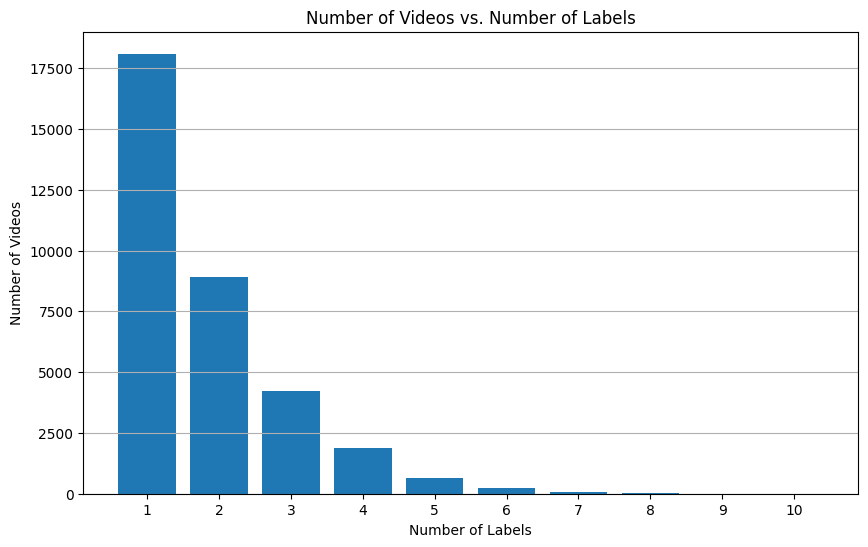

In [16]:
import matplotlib.pyplot as plt
def plot_num_videos_vs_num_labels(df):
    
    mids_to_avoid = ['/m/0c1dj', '/m/093_4n', '/t/dd00077', '/m/04rlf', '/t/dd00092', '/m/026fgl','/m/03m9d0z']
    # Filter out rows with labels to avoid
    df_filtered = df[~df['label'].isin(mids_to_avoid)]
    
    df = df_filtered
    
    # Count the number of labels per video (YTID)
    video_label_counts = df.groupby('YTID').size()
    
    # Count the number of videos with each number of labels
    label_count_distribution = video_label_counts.value_counts().sort_index()
    
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    plt.bar(label_count_distribution.index, label_count_distribution.values)
    plt.xlabel('Number of Labels')
    plt.ylabel('Number of Videos')
    plt.title('Number of Videos vs. Number of Labels')
    plt.xticks(label_count_distribution.index)
    plt.grid(axis='y')
    plt.show()

plot_num_videos_vs_num_labels(df)

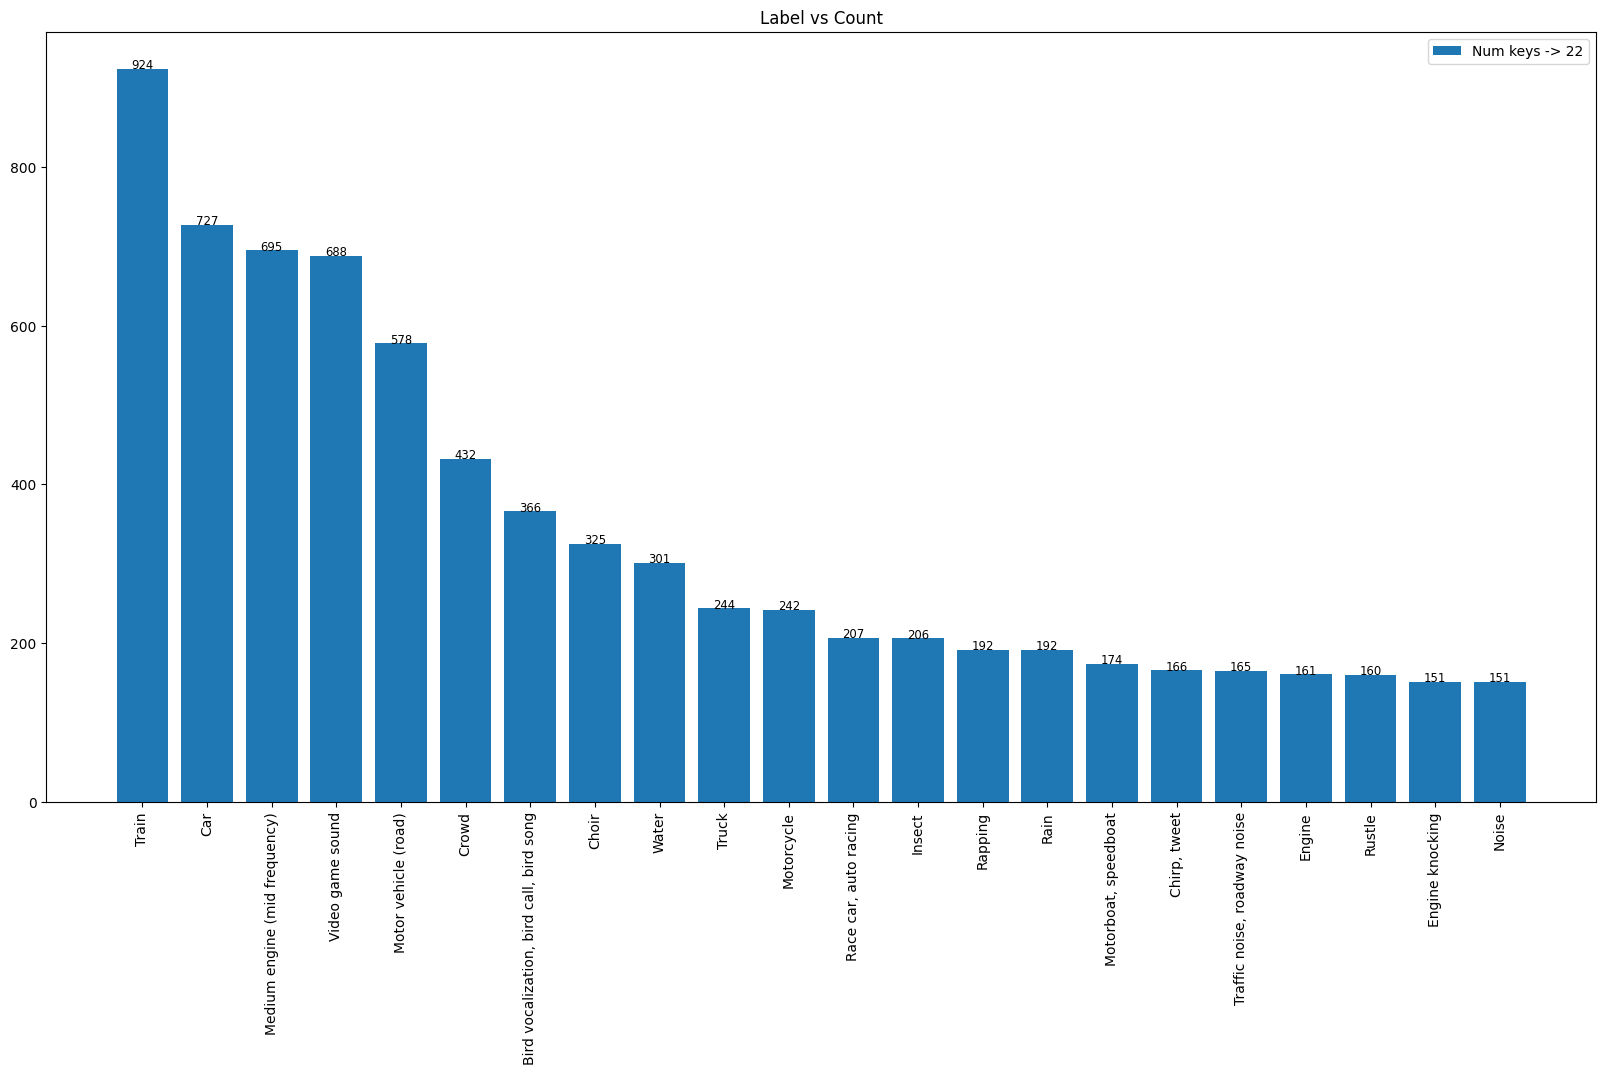

In [19]:

def plot_label_vs_count(label_to_count, mid_to_label,min_num_samples ):
    """
    Plots a bar chart of labels vs. their counts.
    
    Args:
        label_to_count (dict): Dictionary mapping labels to their counts.
        mid_to_label (pd.DataFrame): DataFrame containing label mapping.
        min_num_samples (int): Minimum number of samples for a label to be included in the plot.
    Returns:
        None
    """
    plt.figure(figsize=(20, 10))
    label_to_count = {mid_to_label[mid_to_label['mid'] == k]['label'].values[0]: v for k, v in label_to_count.items()}
    # keep only labels with samples greater than min_nu_samples and keep key with key_idx
    label_to_count = {k: v for k, v in label_to_count.items() if v > min_num_samples}
    # plot
    plt.bar(label_to_count.keys(), label_to_count.values())
    for i, v in enumerate(label_to_count.values()):
        plt.text(i, v, str(v), ha='center', fontsize='small')
    plt.title('Label vs Count')
    plt.xticks(rotation=90)
    # in plot legend add text saying num keys
    plt.legend([f'Num keys -> {len(label_to_count)}'])
    plt.show()


def process_youtube_data_with_max(df, with_music=False, eval=False, labels_considered=[]):
    """
    Process YouTube data to find the label with the maximum duration for each YTID,
    and then count and print the labels in descending order of their counts.
    
    Args:
        df (pd.DataFrame): DataFrame containing YouTube segment data.
    
    Returns:
        ytid_to_label_max_duration (dict): mapping YTID to label with the maximum duration.
        label_to_count (dict): mapping label to its count.
    """
    dir = '/disk1/audioset/' + split_type+'/videos/'
    # Convert DataFrame to dictionary records
    data = df.to_dict('records')
    mids_to_avoid = [ '/m/0c1dj', '/m/093_4n', '/t/dd00077', '/m/04rlf', '/t/dd00092','/m/096m7z'] # ['Sound Effect', 'Background Noise', 'Mechanisms', 'Music','Noise']
    # '/m/026fgl','/m/03m9d0z' -> 'Wind noise (microphone), 'Wind'
    # Initialize the dictionary to store the label with max duration for each YTID
    ytid_to_label = {}
    files_list = os.listdir(dir)
    # Iterate over each row in the data
    for row in data:
        ytid = row['YTID']
        label = row['label']
        duration = row['duration']

        # If the YTID is not in the dictionary, or if the current duration is greater than the stored one
        if (ytid not in ytid_to_label or duration > ytid_to_label[ytid]['duration'] )and not (with_music and (label in mids_to_avoid)):
            if eval and label not in labels_considered:
                continue
            ytid_to_label[ytid] = {'label': label, 'duration': duration, 'start_time': row['start_time_seconds'], 'end_time': row['end_time_seconds']}

    # Create a final dictionary with YTID to the label with the max duration
    ytid_to_label_max_duration = {ytid: value['label'] for ytid, value in ytid_to_label.items()}

    # Get label to count dictionary
    label_to_count = {}
    for ytid, label in ytid_to_label_max_duration.items():
        if label in label_to_count:
            label_to_count[label] += 1
        else:
            label_to_count[label] = 1

    # Sort the label to count dictionary by count in descending order
    label_to_count = dict(sorted(label_to_count.items(), key=lambda item: item[1], reverse=True))

    # Print the labels and their counts in descending order
    # idx = 0
    # for mid, count in label_to_count.items():
    #     idx += 1
    #     label = mid_to_label[mid_to_label['mid'] == mid]['label'].values[0]
    #     print(f'{label} ({idx}) -> {count}')

    return ytid_to_label_max_duration, label_to_count, ytid_to_label

def process_youtube_data_filtered(df, with_music=False, eval=False, labels_considered=[]):
    """
    Process YouTube data to filter out YTIDs with only one label after avoiding certain labels,
    and then find the label with the maximum duration for each remaining YTID,
    and then count and print the labels in descending order of their counts.
    
    Args:
        df (pd.DataFrame): DataFrame containing YouTube segment data.
    
    Returns:
        ytid_to_label_max_duration (dict): mapping YTID to label with the maximum duration.
        label_to_count (dict): mapping label to its count.
    """
    mids_to_avoid = ['/m/0c1dj', '/m/093_4n', '/t/dd00077', '/m/04rlf', '/t/dd00092', '/m/026fgl','/m/03m9d0z']
    
    # Filter out rows with labels to avoid
    df_filtered = df[~df['label'].isin(mids_to_avoid)]
    
    # Filter out YTIDs with only one label
    ytid_counts = df_filtered['YTID'].value_counts()
    ytids_to_include = ytid_counts[ytid_counts > 1].index
    df_filtered = df_filtered[df_filtered['YTID'].isin(ytids_to_include)]
    
    # Convert DataFrame to dictionary records
    data = df_filtered.to_dict('records')

    # Initialize the dictionary to store the label with max duration for each YTID
    ytid_to_label = {}

    # Iterate over each row in the data
    for row in data:
        ytid = row['YTID']
        label = row['label']
        duration = row['duration']

        # If the YTID is not in the dictionary, or if the current duration is greater than the stored one
        if (ytid not in ytid_to_label or duration > ytid_to_label[ytid]['duration']) and not (with_music and (label in mids_to_avoid)):
            if eval and label not in labels_considered:
                continue
            ytid_to_label[ytid] = {'label': label, 'duration': duration, 'start_time': row['start_time_seconds'], 'end_time': row['end_time_seconds']}

    # Create a final dictionary with YTID to the label with the max duration
    ytid_to_label_and_duration = {ytid: value['label'] for ytid, value in ytid_to_label.items()}

    # Get label to count dictionary
    label_to_count = {}
    for ytid, label in ytid_to_label_and_duration.items():
        if label in label_to_count:
            label_to_count[label] += 1
        else:
            label_to_count[label] = 1

    # Sort the label to count dictionary by count in descending order
    label_to_count = dict(sorted(label_to_count.items(), key=lambda item: item[1], reverse=True))

    return ytid_to_label_and_duration, label_to_count, ytid_to_label


label_selection_config_train = {
"min_num_samples_per_class" : 150,
"min_num_samples_per_for_visual_stimuli":100,
"target_num_samples" : 450
}
label_selection_config_eval = {
"min_num_samples_per_class" : 10,
"min_num_samples_per_for_visual_stimuli":50,
"target_num_samples" : 150
}
if split_type == 'train':
    label_selection_config = label_selection_config_train
    eval = False
elif split_type == 'eval':
    label_selection_config = label_selection_config_eval
    eval = True
else:
    raise NotImplementedError(f"Split type {split_type} not implemented")


# labels_considered = []
# with open('/disk1/audioset/annotations/it1_audioset_labels.json', 'r') as f:
#     labels_considered = json.load(f)
#     print(f"Num labels considered -> {len(labels_considered)}")


ytid_to_label_max_duration, label_to_count, ytid_to_label = process_youtube_data_filtered(df, with_music=True, eval = eval)
# ytid_to_label_max_duration, label_to_count, ytid_to_label = process_youtube_data_with_max(df, with_music=True, eval = eval,labels_considered=labels_considered)

plot_label_vs_count(label_to_count, mid_to_label,label_selection_config["min_num_samples_per_class"] )

# ytid_to_label_max_duration_no_music, label_to_count_no_music, ytid_to_label_no_music = process_youtube_data(df, mid_to_label,with_music=True)

# plot_label_vs_count(label_to_count_no_music, mid_to_label,label_selection_config["min_num_samples"] )

## OBSERVATION
- Since most of the youtube videos have music since the source of audioset is youtube, we can skip music as well, but lets have thought reg this fro next iteration of the dataset.
- Advantages: Increase in num labels with given threshold and less skew

In [14]:
# In ytid_to_label keep only keys that have label with count greater than min_num_samples
ytid_to_label = {k: v for k, v in ytid_to_label.items() if label_to_count[v['label']] > label_selection_config["min_num_samples_per_class"]}
# convert ytid_to_label to DataFrame
ytid_to_label_df = pd.DataFrame.from_dict(ytid_to_label, orient='index')
ytid_to_label_df = ytid_to_label_df.reset_index()
ytid_to_label_df.columns = ['YTID', 'label','duration', 'start_time', 'end_time']
ytid_to_label_df.head()

,YTID,label,duration,start_time,end_time
0,NQNTnl0zaqU,/m/0_ksk,2.299,1.947,4.246
1,-FI_F5Lclrg,/m/0bzvm2,10.000,0.000,10.000
2,seUr9_LHUMQ,/m/07pqc89,10.000,0.000,10.000
3,ZvAdd4Jb1xA,/m/03m9d0z,10.000,0.000,10.000
4,7s1hTxxxKW8,/m/07qwyj0,10.000,0.000,10.000


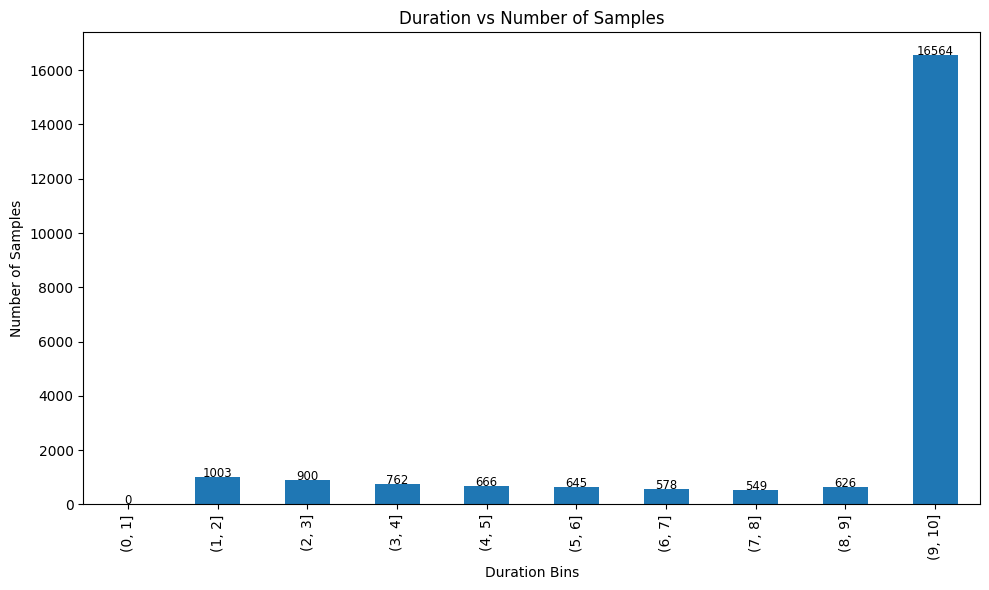

In [5]:
# plot binned time on x with 1sec and num samples in that bin on y
def plot_binned_time_vs_num_samples(df, bin_size=1,add_coloumn_of_probs=True):
    base_dir = '/disk1/audioset/' + split_type+'/videos/'
    bins = range(0, int(df['end_time'].max()) + bin_size, bin_size)
    df['binned_duration'] = pd.cut(df['duration'], bins)
    num_samples_per_bin = df['binned_duration'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    num_samples_per_bin.plot(kind='bar')
    plt.title('Duration vs Number of Samples')
    plt.xlabel('Duration Bins')
    plt.ylabel('Number of Samples')
    # add count on top of each bar
    for i, v in enumerate(num_samples_per_bin):
        plt.text(i, v, str(v), ha='center', fontsize='small')
    plt.tight_layout()
    plt.show()
    if add_coloumn_of_probs:
        # add prbs_with_duration coloumn to df with inverse probality of duration with respect to num_samples_per_bin
        df['prbs_with_duration'] = df['binned_duration'].apply(lambda x: len(df)/num_samples_per_bin[x])
        # get YTID of all samples and check if it is present in base_dir else keep its prob as -50
        videos_list = os.listdir(base_dir)
        df['is_present'] = df['YTID'].apply(lambda x: x + '.mp4' in videos_list)
        df['prbs_with_duration'] = df.apply(lambda x: x['prbs_with_duration'] if x['is_present'] else 0.0001, axis=1)
    return df

ytid_to_label_df = plot_binned_time_vs_num_samples(ytid_to_label_df,add_coloumn_of_probs=True)

In [16]:
# give top 20 labels in the region of 9 to 10 sec
ytid_to_label_df_9_10 = ytid_to_label_df[(ytid_to_label_df['duration'] >= 9) & (ytid_to_label_df['duration'] < 10)]
# print(ytid_to_label_df_9_10['label'].value_counts().head(20))
# use mid_to_label to convert mid to display name
ytid_to_label_df_9_10['label'] = ytid_to_label_df_9_10['label'].apply(lambda x: mid_to_label[mid_to_label['mid']==x]['label'].values[0])
print(ytid_to_label_df_9_10['label'].value_counts().head(20))

Wind                               564
Medium engine (mid frequency)      320
Car                                248
Video game sound                   152
Train                              109
Motor vehicle (road)               108
Sine wave                           88
Engine                              86
Water                               77
Truck                               72
Crowd                               68
Motorcycle                          65
Siren                               56
Fire engine, fire truck (siren)     53
Engine knocking                     45
Vehicle                             44
Rain                                42
Insect                              41
Heavy engine (low frequency)        40
Motorboat, speedboat                39
Name: label, dtype: int64


/tmp/ipykernel_1810032/2145682358.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ytid_to_label_df_9_10['label'] = ytid_to_label_df_9_10['label'].apply(lambda x: mid_to_label[mid_to_label['mid']==x]['label'].values[0])


In [17]:
ytid_to_label_df.head()

,YTID,label,duration,start_time,end_time,binned_duration,prbs_with_duration,is_present
0,NQNTnl0zaqU,/m/0_ksk,2.299,1.947,4.246,"(2, 3]",24.770000,True
1,-FI_F5Lclrg,/m/0bzvm2,10.000,0.000,10.000,"(9, 10]",0.000100,False
2,seUr9_LHUMQ,/m/07pqc89,10.000,0.000,10.000,"(9, 10]",0.000100,False
3,ZvAdd4Jb1xA,/m/03m9d0z,10.000,0.000,10.000,"(9, 10]",0.000100,False
4,7s1hTxxxKW8,/m/07qwyj0,10.000,0.000,10.000,"(9, 10]",1.345871,True


### OBSERVATION
- Note that most of the labels are almost 10 sec long, this dilutes the purposed of going for a segmented dataset, it is fine for first iteration, but for next iteration we can go for a more fine grained dataset, with multi labels considered for a single video or we can backoff to total Audioset with just labels of noise.
- But anyway as we would randomly select the labels with inverse probabilities upto max of min_num_samples x max_repeat_ration we can avoid this skew.

In [18]:
# save df to json
ytid_to_label_df.to_json(f'/disk1/audioset/annotations/it1_audioset_anns_{split_type}.json', orient='records')

### LOAD ABOVE FILE FOR FURTHER ANALYSIS

In [2]:
import pandas as pd
import os
import numpy as np

split_type = 'train'
with open(f'/disk1/audioset/annotations/it1_audioset_anns_{split_type}.json', 'r') as f:
    ytid_to_label_df = pd.read_json(f)
ytid_to_label_df.head()
# print the top 5 labels with their num occurences that have duration greater than 9 sec
# ytid_to_label_df = ytid_to_label_df[ytid_to_label_df['duration'] > 9]
# label_to_count = ytid_to_label_df['label'].value_counts()
# print with their counts
# print(label_to_count.head(5))

,YTID,label,duration,start_time,end_time,binned_duration,prbs_with_duration,is_present
0,NQNTnl0zaqU,/m/0_ksk,2.299,1.947,4.246,"{'closed': 'right', 'closed_left': False, 'clo...",24.770000,True
1,-FI_F5Lclrg,/m/0bzvm2,10.000,0.000,10.000,"{'closed': 'right', 'closed_left': False, 'clo...",0.000100,False
2,seUr9_LHUMQ,/m/07pqc89,10.000,0.000,10.000,"{'closed': 'right', 'closed_left': False, 'clo...",0.000100,False
3,ZvAdd4Jb1xA,/m/03m9d0z,10.000,0.000,10.000,"{'closed': 'right', 'closed_left': False, 'clo...",0.000100,False
4,7s1hTxxxKW8,/m/07qwyj0,10.000,0.000,10.000,"{'closed': 'right', 'closed_left': False, 'clo...",1.345871,True


## Making final dataset and samples selected for dataset to mix with People's speech

### consider for more label skew handling without compramising on the number of unique samples by selecting some samples without repitition first and then selecting the rest with repitition

In [20]:

samples_per_class = label_selection_config["target_num_samples"]
final_anns = pd.DataFrame()
all_labels = ytid_to_label_df['label'].unique()

for label in all_labels:
    df = ytid_to_label_df[ytid_to_label_df['label'] == label]
    if len(df) > samples_per_class:
        # Sample without replacement when enough samples are available
        df = df.sample(samples_per_class, weights=df['prbs_with_duration'], replace=False, random_state=42)
    else:
        # Ensure at least N unique samples
        unique_samples = df.sample(min(len(df), label_selection_config["min_num_samples_per_for_visual_stimuli"]), weights=df['prbs_with_duration'], replace=False, random_state=42)

        # Sample the remaining samples with replacement to reach the required number
        additional_samples_needed = samples_per_class - len(unique_samples)
        if additional_samples_needed > 0:
            additional_samples = df.sample(additional_samples_needed, weights=df['prbs_with_duration'], replace=True, random_state=42)
            df = pd.concat([unique_samples, additional_samples])
        else:
            df = unique_samples
    final_anns = pd.concat([final_anns, df])

final_anns.reset_index(drop=True, inplace=True)
print(len(final_anns))
# save final_anns to json
# final_anns.to_json(f'/disk1/audioset/annotations/it1_audioset_anns_final_{split_type}.json', orient='records')

27000


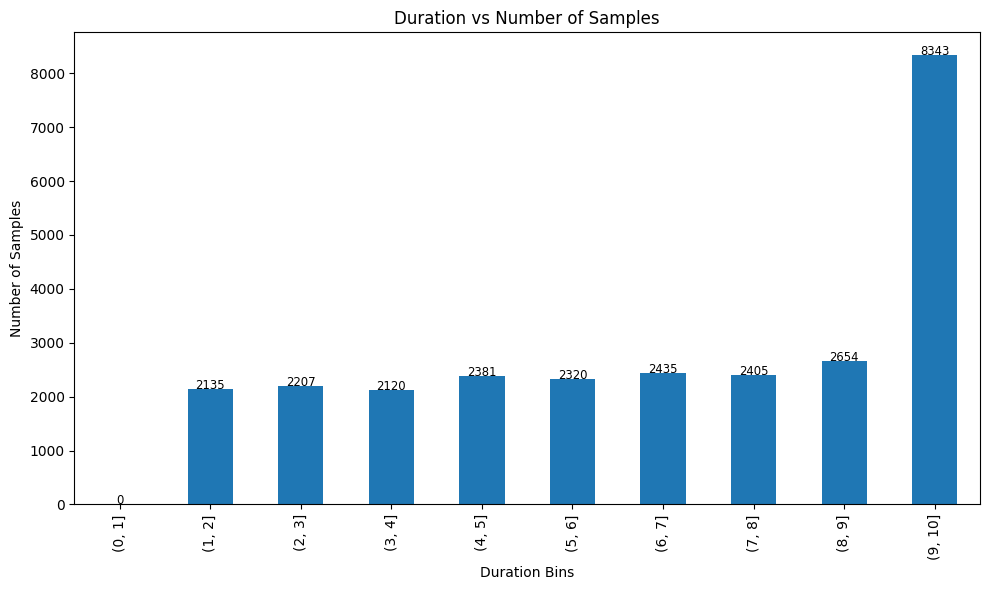

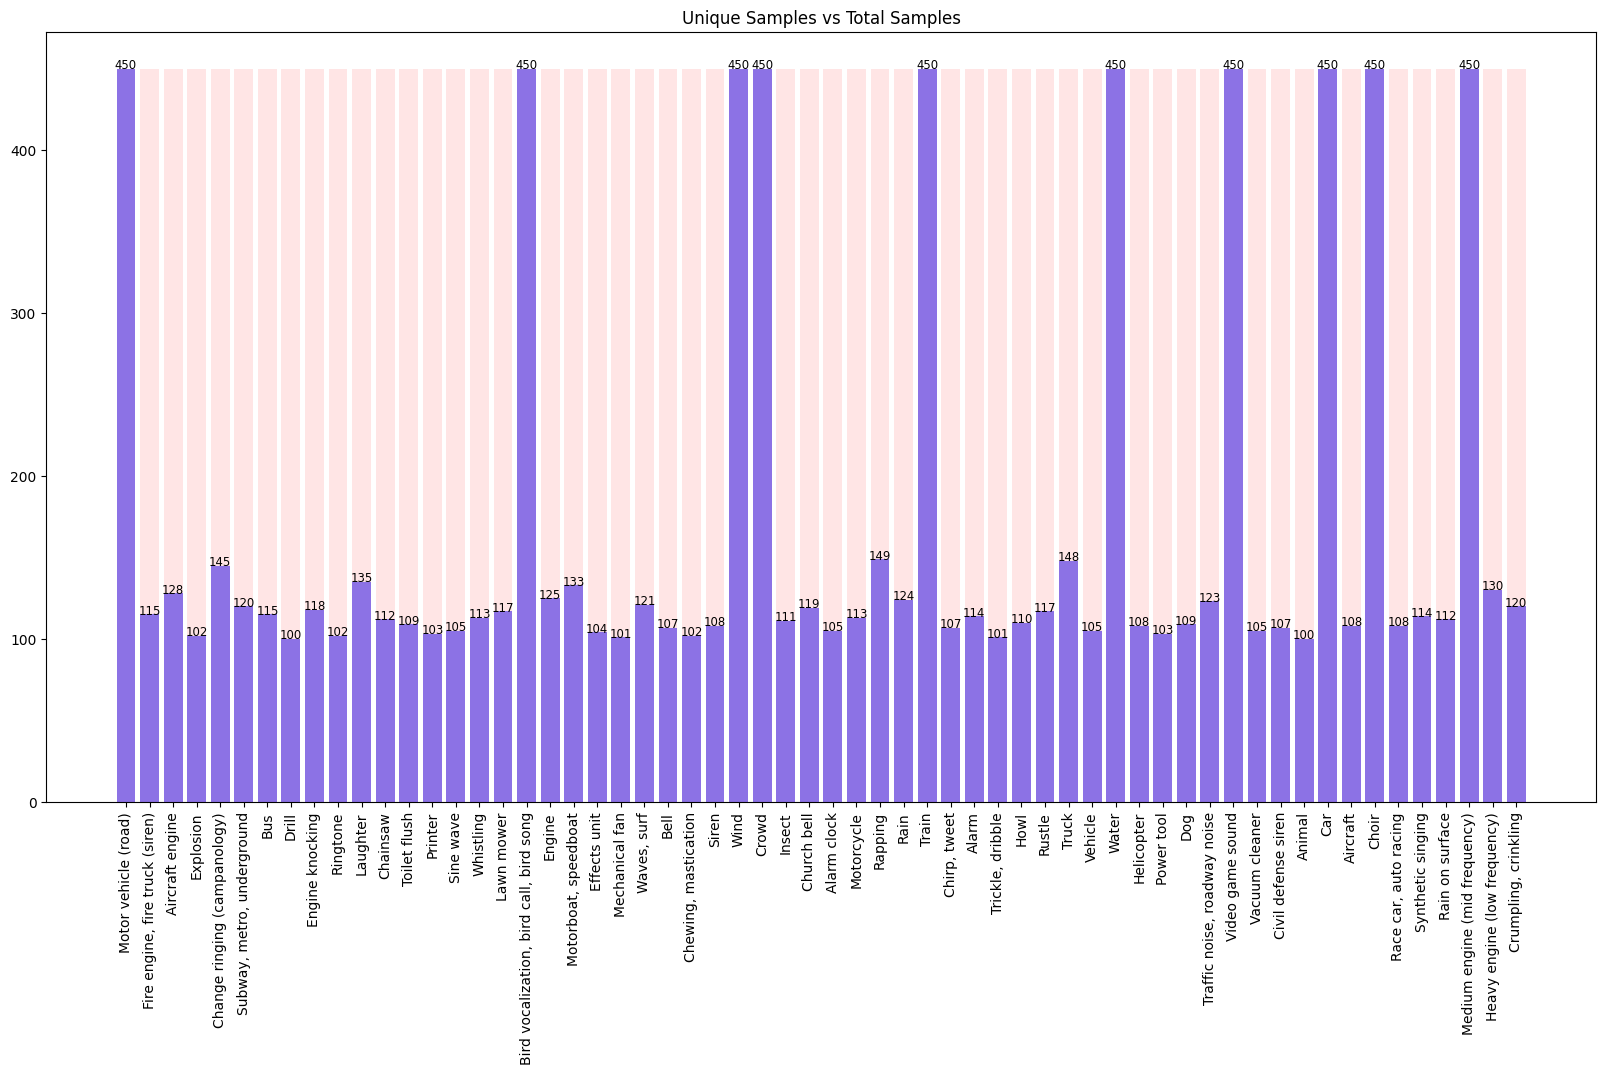

In [21]:
# final_anns = json.load(open(f'/disk1/audioset/annotations/it1_audioset_anns_final_{split_type}.json'))
plot_binned_time_vs_num_samples(final_anns,add_coloumn_of_probs=False)
def plot_unique_samples_vs_total_samples(df):
    label_to_count = df['label'].value_counts()
    label_to_unique_count = df.groupby('label')['YTID'].nunique()
    plt.figure(figsize=(20, 10))
    # use mid_to_label to convert mid to label
    label_to_unique_count = {mid_to_label[mid_to_label['mid'] == k]['label'].values[0]: v for k, v in label_to_unique_count.items()}
    label_to_count = {mid_to_label[mid_to_label['mid'] == k]['label'].values[0]: v for k, v in label_to_count.items()}
    plt.bar(label_to_unique_count.keys(), label_to_unique_count.values(), color='b', alpha=0.5)
    # keep counts on top of bar
    for i, v in enumerate(label_to_unique_count.values()):
        plt.text(i, v, str(v), ha='center', fontsize='small')
    plt.bar(label_to_count.keys(), label_to_count.values(), color='r', alpha=0.1)
    plt.title('Unique Samples vs Total Samples')
    # x labels are rotated by 90 degrees for readability
    plt.xticks(rotation=90)
    plt.show()

mid_to_label = pd.read_csv('/disk1/audioset/annotations/mid_to_display_name.tsv', sep='\t', names=['mid', 'label'])
split_type = 'train'
final_anns = pd.read_json(f'/disk1/audioset/annotations/it1_audioset_anns_final_{split_type}.json')
plot_unique_samples_vs_total_samples(final_anns)


In [9]:
import json
labels_list = final_anns['label'].unique()
print(f"Num labels -> {len(labels_list)}")
# save it as json
with open('/disk1/audioset/annotations/it1_audioset_labels.json', 'w') as f:
    json.dump(labels_list.tolist(), f)
    


Num labels -> 60


## LOADING ABOVE FINAL AUDIOSET ANNOTATION FOR DOWNLOADS ANALYSIS

In [23]:
import json
import pandas as pd
import os
file = f'/disk1/audioset/annotations/it1_audioset_anns_final_{split_type}.json'
file_with_audioset_info = f'/disk1/audioset/annotations/audioset_{split_type}_strong.csv'
videos_dir = f'/disk1/audioset/{split_type}/videos'
videos_list = os.listdir(videos_dir)

data = {}
with open(file, 'r') as f:
    data = json.load(f)

count = 0
missing_count = 0
# make unique set of ann['YTID'] and check if it is in videos_list
df_with_audioset_info = pd.read_csv(file_with_audioset_info)
missing_df = pd.DataFrame()
all_ytids = set([ann['YTID'] for ann in data])
for vid in all_ytids:
    video_id_al_num = ''.join(e for e in vid if e.isalnum())
    if video_id_al_num+'.mp4' in videos_list:
        count += 1
    else:
        missing_count += 1
        # find the row with YTID in df_with_audioset_info after doing df_with_audioset_info -> YTIDs with only alnum
        missing_df = pd.concat([missing_df, df_with_audioset_info[df_with_audioset_info['YTID'] == vid]])


print(count, missing_count)

# save missing_df to csv
missing_df.to_csv('/disk1/audioset/annotations/missing_files_{split_type}.csv', index=False)

10084 126
